# Predict Zero-inflated and Long-tailed Outcomes

## Load Dataset

In [48]:
import pandas as pd
import numpy as np
import random
from ucimlrepo import fetch_ucirepo 
import boto3
import json
from tqdm.auto import tqdm
import time
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from scipy.stats import pearsonr
def calculate_regression_metrics(y_true, y_pred):
    return {
        'root_mean_squared_error': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mean_squared_error': mean_squared_error(y_true, y_pred),
        'mean_absolute_error': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'pearsonr': pearsonr(y_true, y_pred)[0],  # Pearson correlation coefficient
        'median_absolute_error': median_absolute_error(y_true, y_pred)
    }

def string_to_yearmon(date):
    date = date.split()
    date = date[0].split('/') + date[1].split(':')
    date = date[2] + '-' + date[0].zfill(2) #+ '-' + date[1].zfill(2) + ' ' + date[3].zfill(2) + ':' + date[4].zfill(2)
    return date

def call_llama(system_prompt, input):
    template = f"""<s>[INST] <<SYS>>{system_prompt}<</SYS>>{input}[/INST]"""
    client = boto3.client(service_name='bedrock-runtime',region_name='us-west-2')
    body = json.dumps({
        "prompt": template,
        "temperature": 0.,
        "top_p": 0.9,
        "max_gen_len": 2048,
    })
    response = client.invoke_model(
        body=body,
        modelId='us.meta.llama3-2-90b-instruct-v1:0',
        accept='application/json',
        contentType='application/json'
    )
    response_body = json.loads(response['body'].read())
    return response_body

def call_claude(system_prompt, input):
    client = boto3.client(service_name='bedrock-runtime',region_name='us-west-2')
    body=json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 2048,
            "messages": [
                {
                    "role": "user",
                    "content": [
                    {
                        "type": "text",
                        "text": system_prompt + '\n' + input,
                    }
                    ]
                }
                ]
        }  
    )  

    
    response = client.invoke_model(body=body, 
                                   modelId='anthropic.claude-3-5-sonnet-20241022-v2:0',
                                   contentType='application/json',
                                   accept='application/json')
    response_body = json.loads(response.get('body').read())
   
    return response_body

## Clean Dataset

In [2]:
online_retail = fetch_ucirepo(id=352) 
transaction_df = online_retail['data']['original']
transaction_df.shape

(541909, 8)

In [3]:
#create yearmon for train-valid split
transaction_df['yearmon'] = transaction_df.InvoiceDate.map(string_to_yearmon)

#get rid of transactions without cid
transaction_df = transaction_df[~transaction_df.CustomerID.isna()].reset_index(drop=True)

#fill in unknown descriptions
transaction_df.Description = transaction_df.Description.fillna('UNKNOWN')

#convert customer id to string
transaction_df['CustomerID'] = transaction_df['CustomerID'].map(lambda x: str(int(x)))

transaction_df.shape

(406829, 9)

In [4]:
#check if still na
transaction_df.isna().mean()

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
yearmon        0.0
dtype: float64

In [5]:
#simplify by filtering unit price and quantity to be non-zero (get rid of discounts, cancellations, etc)
transaction_df = transaction_df[(transaction_df.UnitPrice>0)&\
                                (transaction_df.Quantity>0)].reset_index(drop=True)
#add sales
transaction_df['Sales'] = transaction_df.UnitPrice * transaction_df.Quantity
transaction_df.shape

(397884, 10)

## Outcome

In [6]:
feature_period = {'start': '2011-01', 'end': '2011-09'}
outcome_period = {'start': '2011-10', 'end': '2011-12'}

feature_transaction = transaction_df[(transaction_df.yearmon>=feature_period['start'])&\
                                      (transaction_df.yearmon<=feature_period['end'])]
outcome_transaction = transaction_df[(transaction_df.yearmon>=outcome_period['start'])&\
                                      (transaction_df.yearmon<=outcome_period['end'])]
feature_transaction.shape, outcome_transaction.shape

((240338, 10), (131389, 10))

In [7]:
#aggregate sales during outcome period
outcome_sales = outcome_transaction.groupby('CustomerID').Sales.sum().reset_index()
outcome_sales

,CustomerID,Sales
0,12347,1519.14
1,12349,1757.55
2,12352,311.73
3,12356,58.35
4,12357,6207.67
...,...,...
2555,18276,335.86
2556,18277,110.38
2557,18282,77.84
2558,18283,974.21


In [8]:
#aggregate sales during feature period
feature_sales = feature_transaction.groupby('CustomerID').Sales.sum().reset_index()
feature_sales

,CustomerID,Sales
0,12346,77183.60
1,12347,2079.07
2,12348,904.44
3,12350,334.40
4,12352,2194.31
...,...,...
3433,18280,180.60
3434,18281,80.82
3435,18282,100.21
3436,18283,1120.67


In [9]:
#merge to get TargetSales including those who spent during feature period but not during outcome (zeroes)
outcome_df = feature_sales[['CustomerID']].merge(outcome_sales, on='CustomerID', how='left')
outcome_df['Sales'] = outcome_df['Sales'].fillna(0)
outcome_df.columns = ['CustomerID', 'TargetSales']
outcome_df

,CustomerID,TargetSales
0,12346,0.00
1,12347,1519.14
2,12348,0.00
3,12350,0.00
4,12352,311.73
...,...,...
3433,18280,0.00
3434,18281,0.00
3435,18282,77.84
3436,18283,974.21


In [10]:
#confirm zero-inflated, long-tailed
outcome_df.TargetSales.describe(percentiles=[i/10 for i in range(10)])

count      3438.000000
mean        666.245829
std        4016.843037
min           0.000000
0%            0.000000
10%           0.000000
20%           0.000000
30%           0.000000
40%           0.000000
50%         102.005000
60%         263.006000
70%         425.790000
80%         705.878000
90%        1273.611000
max      168469.600000
Name: TargetSales, dtype: float64

<AxesSubplot:>

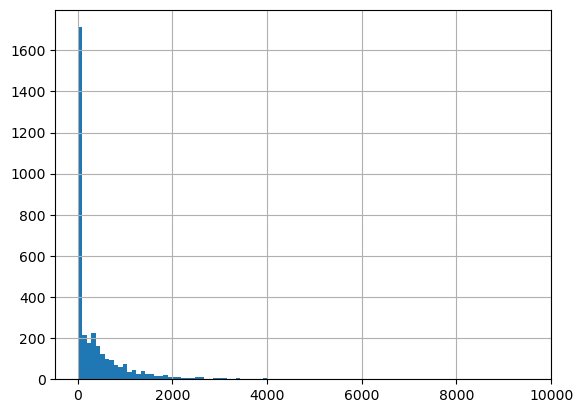

In [11]:
#confirm zero-inflated, long-tailed
outcome_df[outcome_df.TargetSales<=10_000].TargetSales.hist(bins=100)

## Feature

### Classify `Description` into `Category`

In [12]:
feature_transaction.Description.nunique()

3548

#### Get `Category`

In [13]:
descriptions = feature_transaction.Description.unique().tolist()
print(descriptions[:5])

#randomize descriptions with seed 112 to get which categories we should use
np.random.seed(112)
random_descriptions = np.random.choice(descriptions, 1000, replace=False)
print(random_descriptions[:5])

['JUMBO BAG PINK POLKADOT', 'BLUE POLKADOT WRAP', 'RED RETROSPOT WRAP ', 'RECYCLING BAG RETROSPOT ', 'RED RETROSPOT SHOPPER BAG']
['MODERN FLORAL STATIONERY SET' 'PURPLE BERTIE GLASS BEAD BAG CHARM'
 'PARTY INVITES SPACEMAN' 'MONTANA DIAMOND CLUSTER EARRINGS'
 'SKULLS  DESIGN  COTTON TOTE BAG']


In [14]:
res = call_llama(
    'You are a product categorization assistant at a retail website.',
    'Given the following product descriptions, come up with a few product categories they should be classified into.'+'\n'.join(random_descriptions)
    )

print(res['generation'])

 <<SYS>>Based on the product descriptions, I would categorize them into the following categories:

1. Home Decor:
	* Wall art
	* Decorative items (e.g. vases, figurines, etc.)
	* Lighting (e.g. candles, lanterns, etc.)
	* Textiles (e.g. throw pillows, blankets, etc.)
2. Kitchen and Dining:
	* Cookware and utensils
	* Tableware (e.g. plates, cups, etc.)
	* Kitchen decor (e.g. wall art, etc.)
	* Food and drink items (e.g. tea, coffee, etc.)
3. Fashion and Accessories:
	* Jewelry (e.g. necklaces, earrings, etc.)
	* Handbags and wallets
	* Clothing and accessories (e.g. scarves, hats, etc.)
4. Stationery and Gifts:
	* Cards and gift wrap
	* Stationery (e.g. notebooks, pens, etc.)
	* Gift items (e.g. mugs, keychains, etc.)
5. Toys and Games:
	* Toys (e.g. stuffed animals, puzzles, etc.)
	* Games and puzzles
6. Seasonal and Holiday:
	* Christmas decorations and gifts
	* Easter decorations and gifts
	* Other seasonal items (e.g. Halloween, etc.)
7. Personal Care and Wellness:
	* Beauty and pe

In [15]:
res

{'generation': ' <<SYS>>Based on the product descriptions, I would categorize them into the following categories:\n\n1. Home Decor:\n\t* Wall art\n\t* Decorative items (e.g. vases, figurines, etc.)\n\t* Lighting (e.g. candles, lanterns, etc.)\n\t* Textiles (e.g. throw pillows, blankets, etc.)\n2. Kitchen and Dining:\n\t* Cookware and utensils\n\t* Tableware (e.g. plates, cups, etc.)\n\t* Kitchen decor (e.g. wall art, etc.)\n\t* Food and drink items (e.g. tea, coffee, etc.)\n3. Fashion and Accessories:\n\t* Jewelry (e.g. necklaces, earrings, etc.)\n\t* Handbags and wallets\n\t* Clothing and accessories (e.g. scarves, hats, etc.)\n4. Stationery and Gifts:\n\t* Cards and gift wrap\n\t* Stationery (e.g. notebooks, pens, etc.)\n\t* Gift items (e.g. mugs, keychains, etc.)\n5. Toys and Games:\n\t* Toys (e.g. stuffed animals, puzzles, etc.)\n\t* Games and puzzles\n6. Seasonal and Holiday:\n\t* Christmas decorations and gifts\n\t* Easter decorations and gifts\n\t* Other seasonal items (e.g. Hal

In [16]:
res = call_claude(
    'You are a product categorization assistant at a retail website.',
    'Given the following product descriptions, come up with a few product categories they should be classified into.'+'\n'.join(random_descriptions)
    )

print(res['content'][0]['text'])

Based on these product descriptions, I would suggest the following main categories and subcategories:

1. Home & Garden
- Kitchen & Dining (e.g., tea sets, mugs, plates, cutlery)
- Home Decor (e.g., photo frames, clocks, mirrors, signs)
- Garden (e.g., planters, garden tools, watering cans)
- Storage & Organization (e.g., storage tins, boxes, baskets)
- Lighting (e.g., candle holders, lamps, string lights)

2. Fashion & Accessories
- Jewelry (e.g., necklaces, bracelets, earrings)
- Bags & Purses (e.g., tote bags, cosmetic bags, shoulder bags)
- Hair Accessories (e.g., hair bands, combs, slides)
- Fashion Accessories (e.g., scarves, charms)

3. Gifts & Party Supplies
- Gift Wrap & Packaging (e.g., gift bags, wrapping paper, tissue paper)
- Party Supplies (e.g., party invites, decorations, napkins)
- Greeting Cards
- Gift Sets

4. Seasonal & Holiday
- Christmas Decorations
- Easter Items
- Holiday Gift Items
- Seasonal Decor

5. Children's Items
- Toys & Games
- Children's Accessories
- 

In [17]:
res

{'id': 'msg_bdrk_01M8dtwKkgVx3Sgh6HfbA8YV',
 'type': 'message',
 'role': 'assistant',
 'model': 'claude-3-5-sonnet-20241022',
 'content': [{'type': 'text',
   'text': "Based on these product descriptions, I would suggest the following main categories and subcategories:\n\n1. Home & Garden\n- Kitchen & Dining (e.g., tea sets, mugs, plates, cutlery)\n- Home Decor (e.g., photo frames, clocks, mirrors, signs)\n- Garden (e.g., planters, garden tools, watering cans)\n- Storage & Organization (e.g., storage tins, boxes, baskets)\n- Lighting (e.g., candle holders, lamps, string lights)\n\n2. Fashion & Accessories\n- Jewelry (e.g., necklaces, bracelets, earrings)\n- Bags & Purses (e.g., tote bags, cosmetic bags, shoulder bags)\n- Hair Accessories (e.g., hair bands, combs, slides)\n- Fashion Accessories (e.g., scarves, charms)\n\n3. Gifts & Party Supplies\n- Gift Wrap & Packaging (e.g., gift bags, wrapping paper, tissue paper)\n- Party Supplies (e.g., party invites, decorations, napkins)\n- Gree

LLaMA 3.2 90B Output:
```
<<SYS>>Based on the product descriptions, I would categorize them into the following categories:

1. Home Decor:
	* Wall art
	* Decorative items (e.g. vases, figurines, etc.)
	* Lighting (e.g. candles, lanterns, etc.)
	* Textiles (e.g. throw pillows, blankets, etc.)
2. Kitchen and Dining:
	* Cookware and utensils
	* Tableware (e.g. plates, cups, etc.)
	* Kitchen decor (e.g. signs, magnets, etc.)
	* Food and drink items (e.g. tea, coffee, etc.)
3. Fashion and Accessories:
	* Jewelry (e.g. necklaces, earrings, etc.)
	* Handbags and wallets
	* Clothing and accessories (e.g. scarves, hats, etc.)
4. Stationery and Gifts:
	* Cards and gift wrap
	* Stationery (e.g. notebooks, pens, etc.)
	* Gift items (e.g. mugs, keychains, etc.)
5. Toys and Games:
	* Toys (e.g. stuffed animals, puzzles, etc.)
	* Games and puzzles
6. Seasonal and Holiday:
	* Christmas decorations and gifts
	* Easter decorations and gifts
	* Other seasonal items (e.g. Halloween, etc.)
7. Personal Care and Wellness:
	* Beauty and personal care items (e.g. skincare, haircare, etc.)
	* Wellness and self-care items (e.g. essential oils, etc.)
8. Outdoor and Garden:
	* Garden decor and accessories
	* Outdoor furniture and decor
	* Gardening tools and supplies

Note that some products may fit into multiple categories, but I have assigned them to the one that seems most relevant.
```

Claude 3.5 v2 Output
```
Based on these product descriptions, I would suggest the following main product categories:

1. Home Decor
- Candle holders
- Picture frames
- Wall art & signs
- Clocks
- Cushions & covers
- Storage items
- Decorative objects

2. Jewelry & Accessories
- Necklaces
- Bracelets
- Earrings
- Hair accessories
- Bag charms
- Key rings

3. Garden & Outdoor
- Plant pots
- Garden tools
- Outdoor decorations
- Bird houses
- Garden markers

4. Kitchen & Dining
- Tea sets
- Mugs
- Kitchen storage
- Cutlery
- Baking accessories
- Tea towels

5. Stationery & Paper Goods
- Notebooks
- Gift wrap
- Cards
- Paper decorations
- Writing sets

6. Party & Celebrations
- Party supplies
- Gift bags
- Christmas decorations
- Easter items
- Birthday items

7. Children's Items
- Toys
- Children's tableware
- School supplies
- Kids' accessories

8. Fashion Accessories
- Bags
- Purses
- Scarves
- Travel accessories

9. Bath & Beauty
- Bathroom accessories
- Toiletry bags
- Beauty items

10. Lighting
- Lamps
- String lights
- Tea lights
- Lanterns

These categories cover the main types of products in the list while providing logical groupings for customers to browse.
```

In [18]:
categories = [
    'Home Decor',
    'Kitchen and Dining',
    'Fashion Accessories',
    'Stationary and Gifts',
    'Toys and Games',
    'Seasonal and Holiday',
    'Personal Care and Wellness',
    'Outdoor and Garden',   
]

len(categories)

8

#### Annotate `Category` to `Description`

In [19]:
# #loop through descriptions in batches of batch_size
# res_texts = []
# batch_size = 100
# for i in tqdm(range(0, len(descriptions), batch_size)):
#     batch = descriptions[i:i+batch_size]
#     d = "\n".join(batch)
#     inp = f'''Categorize the following product descriptions into {", ".join(categories)} or Others, if they do not fall into any. 
# Only answer in the following format:

# "product description of product #1"|"product category classified into"
# "product description of product #2"|"product category classified into"
# ...
# "product description of product #n"|"product category classified into"

# Here are the product descriptions:
# {d}
# '''
#     while True:
#         res = call_claude('You are a product categorizer at a retail website', inp)
#         # if res['generation_token_count'] > 1: #for llama
#         if res['usage']['output_tokens'] > 1:
#             break
#         else:
#             print('Retrying...')
#             time.sleep(2)
#     res_text = res['content'][0]['text'].strip().split('\n')
#         #for llama
#         # .replace('[SYS]','').replace('<<SYS>>','')\
#         # .replace('[/SYS]','').replace('<</SYS>>','')\
#     if res_text!='':
#         res_texts.extend(res_text)

In [20]:
# with open('../data/sales_prediction/product_description_category.csv','w') as f:
#     f.write('"product_description"|"category"\n')
#     for i in res_texts:
#         f.write(f'{i}\n')

In [21]:
product_description_category = pd.read_csv('../data/sales_prediction/product_description_category.csv',
                                           sep='|')

#clean product_description
product_description_category['Description'] = descriptions
product_description_category.category.value_counts(normalize=True)

category
Home Decor                    0.328636
Kitchen and Dining            0.195885
Fashion Accessories           0.138670
Stationary and Gifts          0.116122
Seasonal and Holiday          0.087373
Personal Care and Wellness    0.047351
Toys and Games                0.045096
Outdoor and Garden            0.032976
Others                        0.007892
Name: proportion, dtype: float64

In [22]:
feature_transaction_cat = feature_transaction.merge(product_description_category,
                                                    how='inner',
                                                    on = 'Description',)
feature_transaction.shape, feature_transaction_cat.shape

((240338, 10), (240338, 12))

### RFM

In [23]:
#convert invoice date to datetime
feature_transaction_cat['InvoiceDate'] = pd.to_datetime(feature_transaction_cat['InvoiceDate'])

# last date in feature set
current_date = feature_transaction_cat['InvoiceDate'].max()

#rfm
customer_features = feature_transaction_cat.groupby('CustomerID').agg({
    'InvoiceDate': [
        ('recency', lambda x: (current_date - x.max()).days),
        ('first_purchase_date', 'min'),
        ('purchase_day', 'nunique'),
    ],
    'InvoiceNo': [('nb_invoice', 'nunique')],
    'Sales': [
        ('total_sales', 'sum')
    ],
    'StockCode': [('nb_product', 'nunique')],
    'category': [('nb_category', 'nunique')]
}).reset_index()

# Flatten column names
customer_features.columns = [
    'CustomerID',
    'recency',
    'first_purchase_date',
    'purchase_day',
    'nb_invoice',
    'total_sales',
    'nb_product',
    'nb_category'
]

In [24]:
#almost always one purchase a day
(customer_features.purchase_day==customer_features.nb_invoice).mean()

0.977021524141943

In [25]:
customer_features['customer_lifetime'] = (current_date - customer_features['first_purchase_date']).dt.days
customer_features['avg_purchase_frequency'] = customer_features['customer_lifetime'] / customer_features['purchase_day']
customer_features['avg_purchase_value'] = customer_features['total_sales'] / customer_features['purchase_day']

### Category Preference

In [26]:
#category preference
category_sales = feature_transaction_cat.pivot_table(
    values='Sales', 
    index='CustomerID', 
    columns='category', 
    aggfunc='sum', 
    fill_value=0
)
category_sales.columns = [i.lower().replace(' ','_') for i in category_sales.columns]
customer_features = customer_features.merge(category_sales, on='CustomerID', how='left')

total_sales = customer_features['total_sales']
for col in category_sales.columns:
    percentage_col = f'per_{col}'
    customer_features[percentage_col] = customer_features[col] / total_sales

In [27]:
#make sure the categories are not too sparse
(customer_features.iloc[:,-9:]==0).mean()

per_fashion_accessories           0.409831
per_home_decor                    0.081734
per_kitchen_and_dining            0.122455
per_others                        0.765561
per_outdoor_and_garden            0.507853
per_personal_care_and_wellness    0.448226
per_seasonal_and_holiday          0.369401
per_stationary_and_gifts          0.305410
per_toys_and_games                0.487202
dtype: float64

### Putting Them All Together

In [28]:
selected_features = [
 'recency',
 'purchase_day',
 'total_sales',
 'nb_product',
 'nb_category',
 'customer_lifetime',
 'avg_purchase_frequency',
 'avg_purchase_value',
 'per_fashion_accessories',
 'per_home_decor',
 'per_kitchen_and_dining',
 'per_others',
 'per_outdoor_and_garden',
 'per_personal_care_and_wellness',
 'per_seasonal_and_holiday',
 'per_stationary_and_gifts',
 'per_toys_and_games']

In [29]:
customer_features = customer_features[[ 'CustomerID']+selected_features]
customer_features.head()

,CustomerID,recency,purchase_day,total_sales,nb_product,nb_category,customer_lifetime,avg_purchase_frequency,avg_purchase_value,per_fashion_accessories,per_home_decor,per_kitchen_and_dining,per_others,per_outdoor_and_garden,per_personal_care_and_wellness,per_seasonal_and_holiday,per_stationary_and_gifts,per_toys_and_games
0,12346,255,1,77183.60,1,1,255,255.000000,77183.600000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,12347,59,4,2079.07,65,7,247,61.750000,519.767500,0.145834,0.204168,0.294021,0.000000,0.005628,0.147614,0.000000,0.073013,0.129721
2,12348,5,3,904.44,10,4,248,82.666667,301.480000,0.000000,0.000000,0.000000,0.132679,0.000000,0.825970,0.018796,0.022555,0.000000
3,12350,239,1,334.40,17,7,239,239.000000,334.400000,0.240431,0.202751,0.116926,0.172548,0.000000,0.118421,0.000000,0.059211,0.089713
4,12352,2,7,2194.31,47,8,226,32.285714,313.472857,0.000000,0.196531,0.246187,0.474090,0.013535,0.016680,0.008066,0.024404,0.020508


## Merge Features and Outcome

In [30]:
customer_features.shape, outcome_df.shape

((3438, 18), (3438, 2))

In [31]:
df = outcome_df.merge(customer_features, on='CustomerID').drop('CustomerID', axis=1)
df.shape

(3438, 18)

In [32]:
#correlations
df.iloc[:,1:].corr()

,recency,purchase_day,total_sales,nb_product,nb_category,customer_lifetime,avg_purchase_frequency,avg_purchase_value,per_fashion_accessories,per_home_decor,per_kitchen_and_dining,per_others,per_outdoor_and_garden,per_personal_care_and_wellness,per_seasonal_and_holiday,per_stationary_and_gifts,per_toys_and_games
recency,1.000000,-0.299308,-0.132344,-0.287415,-0.326772,0.298853,0.893973,0.008823,-0.020861,0.022013,0.057244,-0.016069,0.071268,-0.082792,-0.085681,-0.017813,-0.009686
purchase_day,-0.299308,1.000000,0.540253,0.690345,0.304621,0.332109,-0.331543,0.027488,0.030683,0.018684,0.025269,0.004299,-0.019992,-0.035665,-0.020392,-0.045384,-0.028187
total_sales,-0.132344,0.540253,1.000000,0.400467,0.137064,0.156018,-0.148762,0.361138,0.016511,-0.013819,0.047834,0.006398,-0.029353,-0.011937,-0.016724,-0.029181,-0.013139
nb_product,-0.287415,0.690345,0.400467,1.000000,0.555551,0.265594,-0.294923,0.061039,-0.003137,-0.017516,0.035615,-0.006842,-0.026371,-0.005309,-0.016586,0.026716,-0.010069
nb_category,-0.326772,0.304621,0.137064,0.555551,1.000000,0.224232,-0.321596,0.019955,0.004863,-0.138372,-0.039363,0.055555,0.041405,0.075882,0.015498,0.152869,0.111150
customer_lifetime,0.298853,0.332109,0.156018,0.265594,0.224232,1.000000,0.358431,0.014933,0.011220,0.066111,0.069175,-0.019971,0.029726,-0.127865,-0.120399,-0.050320,-0.036484
avg_purchase_frequency,0.893973,-0.331543,-0.148762,-0.294923,-0.321596,0.358431,1.000000,0.009157,-0.016093,0.027208,0.037053,-0.027413,0.060369,-0.070352,-0.074799,-0.000546,-0.010612
avg_purchase_value,0.008823,0.027488,0.361138,0.061039,0.019955,0.014933,0.009157,1.000000,-0.003187,-0.056690,0.076862,0.015427,-0.028884,0.004225,-0.000200,-0.012729,-0.002396
per_fashion_accessories,-0.020861,0.030683,0.016511,-0.003137,0.004863,0.011220,-0.016093,-0.003187,1.000000,-0.254015,-0.177775,-0.010436,-0.082834,-0.038493,-0.124719,-0.068166,-0.051486
per_home_decor,0.022013,0.018684,-0.013819,-0.017516,-0.138372,0.066111,0.027208,-0.056690,-0.254015,1.000000,-0.481983,-0.155784,-0.080637,-0.158837,-0.165964,-0.262313,-0.245759


<AxesSubplot:xlabel='TargetSales', ylabel='total_sales'>

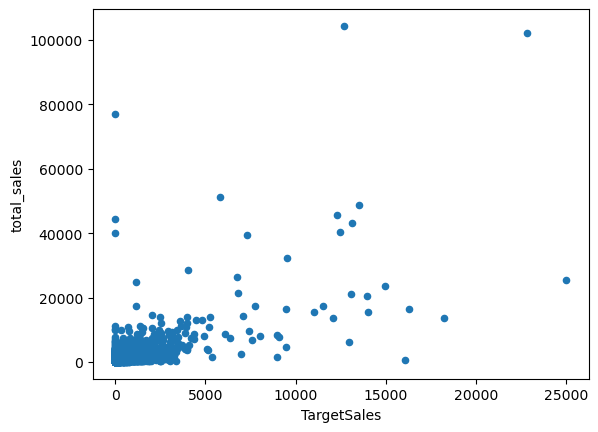

In [33]:
#target and most predictive variable
df[df.TargetSales<=25_000].plot.scatter(x='TargetSales',y='total_sales')

## Train-Valid Splits

In [34]:
#split into train-valid sets
train_df, valid_df = train_test_split(df,
                                      test_size=0.2, 
                                      random_state=112)

In [36]:
pd.concat([train_df.TargetSales.describe(percentiles=[i/10 for i in range(10)]).reset_index(),
valid_df.TargetSales.describe(percentiles=[i/10 for i in range(10)]).reset_index(),], axis=1)

,index,TargetSales,index,TargetSales
0,count,2750.000000,count,688.000000
1,mean,642.650436,mean,760.558808
2,std,4015.305436,std,4024.524400
3,min,0.000000,min,0.000000
4,0%,0.000000,0%,0.000000
5,10%,0.000000,10%,0.000000
6,20%,0.000000,20%,0.000000
7,30%,0.000000,30%,0.000000
8,40%,0.000000,40%,0.000000
9,50%,91.350000,50%,113.575000


## Baseline Regression

In [ ]:
predictor = TabularPredictor(label='TargetSales').fit(train_df)

No path specified. Models will be saved in: "AutogluonModels/ag-20241108_095110"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.9.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Oct 22 16:37:58 UTC 2024
CPU Count:          64
Memory Avail:       468.98 GB / 480.23 GB (97.7%)
Disk Space Avail:   1686.44 GB / 1968.52 GB (85.7%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast trainin

In [ ]:
valid_df['pred_baseline'] = predictor.predict(valid_df.drop(columns=['TargetSales']))

In [ ]:
calculate_regression_metrics(valid_df['TargetSales'], valid_df['pred_baseline'])

{'root_mean_squared_error': 3216.856852660034,
 'mean_squared_error': 10348168.010505818,
 'mean_absolute_error': 635.6823200048402,
 'r2': 0.36016787325567845,
 'pearsonr': 0.6522755429056346,
 'median_absolute_error': 249.23675720214845}

## Regression on Winsorized Outcome

In [50]:
outlier_per = 0.99
outlier_cap_train = train_df['TargetSales'].quantile(outlier_per)
outlier_cap_train

7180.805199999947

In [51]:
train_df['TargetSales_win'] = train_df['TargetSales'].map(lambda x: outlier_cap_train if x> outlier_cap_train else x)
valid_df['TargetSales_win'] = valid_df['TargetSales'].map(lambda x: outlier_cap_train if x> outlier_cap_train else x)

In [52]:
predictor = TabularPredictor(label='TargetSales_win').fit(train_df.drop('TargetSales', axis=1))

No path specified. Models will be saved in: "AutogluonModels/ag-20241108_101500"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.9.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Oct 22 16:37:58 UTC 2024
CPU Count:          64
Memory Avail:       470.59 GB / 480.23 GB (98.0%)
Disk Space Avail:   1686.49 GB / 1968.52 GB (85.7%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast trainin

In [53]:
valid_df['pred_winsorized'] = predictor.predict(valid_df.drop(columns=['TargetSales','TargetSales_win']))

In [54]:
calculate_regression_metrics(valid_df['TargetSales'], valid_df['pred_winsorized'])

{'root_mean_squared_error': 3649.3414061051403,
 'mean_squared_error': 13317692.698313441,
 'mean_absolute_error': 627.4500553117797,
 'r2': 0.17656075608375232,
 'pearsonr': 0.5784062810699505,
 'median_absolute_error': 212.47872924804688}

In [56]:
calculate_regression_metrics(valid_df['TargetSales_win'], valid_df['pred_winsorized'])

{'root_mean_squared_error': 660.8172659679369,
 'mean_squared_error': 436679.4590013391,
 'mean_absolute_error': 376.4380814745696,
 'r2': 0.6314425530191099,
 'pearsonr': 0.8028601839210051,
 'median_absolute_error': 212.47872924804688}